In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment
from scipy.io import loadmat
from tqdm import tqdm

In [16]:
def initialize_membership_matrix(n, c):
    """
    初始化隸屬度矩陣
    n: 數據點數量
    c: 群聚數量
    """
    U = np.random.rand(n, c)
    U /= np.sum(U, axis=1, keepdims=True)
    return U

In [17]:
def update_centroids(data, U, m):
    """
    更新群聚中心點
    data: 數據點 (n_samples, n_features)
    U: 隸屬度矩陣 (n_samples, c)
    m: 模糊權重指數
    """
    um = U ** m
    return (data.T @ um / np.sum(um, axis=0)).T

In [18]:
def update_membership_matrix(data, centroids, m):
    """
    更新隸屬度矩陣
    data: 數據點 (n_samples, n_features)
    centroids: 群聚中心點 (c, n_features)
    m: 模糊權重指數
    """
    n = data.shape[0]
    c = centroids.shape[0]
    p = 2. / (m - 1)
    U = np.zeros((n, c))
    for i in range(n):
        x = data[i]
        dists = np.linalg.norm(x - centroids, axis=1)
        U[i] = 1. / np.sum((dists / dists[:, np.newaxis]) ** p, axis=0)
    return U

In [19]:
def fuzzy_c_means(data, c, m, error=0.005, maxiter=100):
    """
    Fuzzy C-Means 算法實現
    data: 數據點 (n_samples, n_features)
    c: 群聚數量
    m: 模糊權重指數
    error: 收斂誤差閾值
    maxiter: 最大迭代次數
    """
    n = data.shape[0]
    U = initialize_membership_matrix(n, c)
    iteration = 0
    with tqdm(total=maxiter, desc="FCMM Iteration") as pbar:
        while iteration < maxiter:
            U_old = U.copy()
            centroids = update_centroids(data, U, m)
            U = update_membership_matrix(data, centroids, m)
            if np.linalg.norm(U - U_old) < error:
                break
            iteration += 1
            pbar.update(1)
    return U, centroids


In [20]:
# Load salinas Hyperspectral Dataset

mat_data = loadmat('./dataset/salinas/salinas_corrected.mat')
gt_data = loadmat('./dataset/salinas/salinas_gt.mat')

# 提取高光譜影像數據和地面真實值
img = mat_data['salinas_corrected']
gt = gt_data['salinas_gt']

classes = np.unique(gt)

#將三維數據降至二維
data = img.reshape(-1, img.shape[-1])

U, centroids = fuzzy_c_means(data, c=16, m=1.5)
print("Centroids:", centroids)

FCMM Iteration: 100%|██████████| 100/100 [06:36<00:00,  3.97s/it]

Centroids: [[347.59281788 434.91387104 584.95536604 ...   4.95739434   1.8467914
    2.81479794]
 [405.63582763 527.36077787 765.37023733 ...  62.92719907  22.65100005
   35.88973079]
 [310.07350748 397.39925444 570.85703578 ...  17.0393705    5.97214364
    9.60082291]
 ...
 [362.01116351 470.74007464 689.74407164 ...  44.01653205  15.51619553
   24.60631663]
 [352.08320056 453.56778965 646.57585202 ...  37.23777778  13.43519948
   21.22783085]
 [316.45385144 401.76237425 570.39786628 ...  13.28574873   4.73572783
    7.64817362]]


(111104,)
(512, 217)


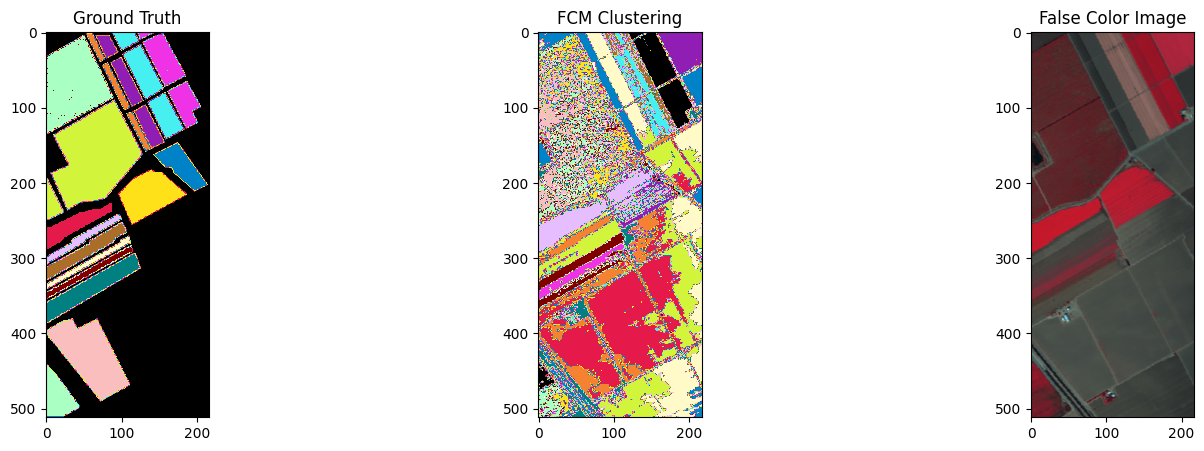

In [24]:
labels = np.argmax(U, axis=1)
print(labels.shape)
clustered_img = labels.reshape(img.shape[:2])
print(clustered_img.shape)

# 定義16種顏色
colors = [
    "#000000", "#e6194b", "#ffe119", "#0082c8", "#f58231", "#911eb4", "#46f0f0", "#f032e6",
    "#d2f53c", "#fabebe", "#008080", "#e6beff", "#aa6e28", "#fffac8", "#800000", "#aaffc3"
]
cmap = ListedColormap(colors)


plt.figure(figsize=(18, 5))

# Ground Truth
plt.subplot(1, 3, 1)
plt.title("Ground Truth")
plt.imshow(gt, cmap=cmap)

# FCM Clustering Result
plt.subplot(1, 3, 2)
plt.title("FCM Clustering")
plt.imshow(clustered_img, cmap=cmap)

# False Color Image (使用波段 50, 27, 17)
false_color_img = img[:, :, [50, 27, 17]]

# 縮放假彩色圖像的值到0-255範圍
false_color_img = (false_color_img - false_color_img.min()) / (false_color_img.max() - false_color_img.min()) * 255
false_color_img = false_color_img.astype(np.uint8)

plt.subplot(1, 3, 3)
plt.title("False Color Image")
plt.imshow(false_color_img)

plt.show()

Accuracy: 36.78%


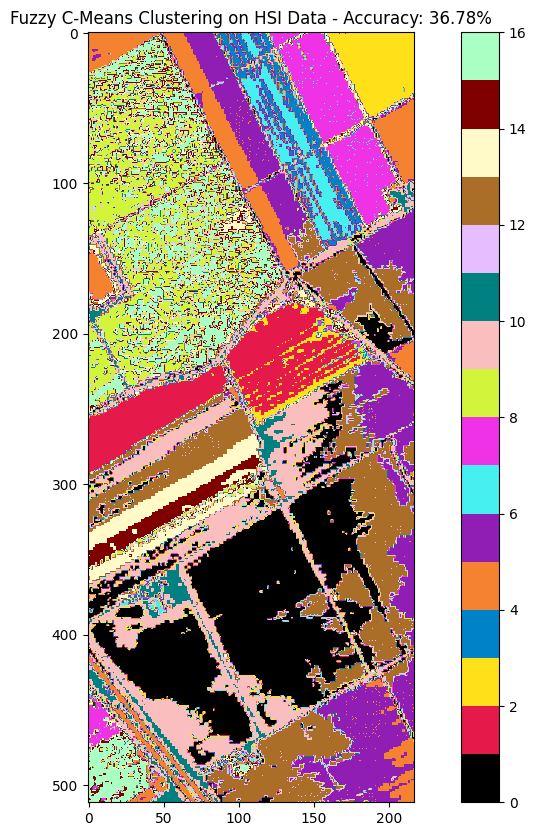

In [25]:
# 並且已經有 gt 加載和重塑為一維向量
gt_flat = gt.flatten()

# 計算混淆矩陣
cm = confusion_matrix(gt_flat, labels)

# 使用匈牙利算法找到最佳標籤對應
row_ind, col_ind = linear_sum_assignment(-cm)  # 對成本矩陣取負值以求最大化

# 建立標籤映射，根據找到的對應關系重映射 FCM 的結果
label_mapping = {col: row for col, row in zip(col_ind, row_ind)}
remapped_labels = np.array([label_mapping[label] for label in labels])

# 計算重映射後的準確率
accuracy = np.sum(remapped_labels == gt_flat) / gt_flat.size
print(f"Accuracy: {accuracy * 100:.2f}%")

# 可視化重映射後的分群結果
remapped_clustered_img = remapped_labels.reshape(img.shape[:2])

plt.figure(figsize=(12, 10))
plt.imshow(remapped_clustered_img, cmap=cmap)
plt.colorbar()
plt.title(f'Fuzzy C-Means Clustering on HSI Data - Accuracy: {accuracy * 100:.2f}%')
plt.show()